# A tour of PyCIEMSS interfaces and functionality

### Load dependencies and interfaces

In [1]:
import os
import pyciemss
import torch
import pandas as pd

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

smoke_test = ('CI' in os.environ)

### Select models and data

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

### Set parameters for sampling

In [3]:
start_time = 0.0
end_time = 100.0
logging_step_size = 10.0
num_samples = 3 if smoke_test else 10

## Sample interface
Take `num_samples` number of samples from the (prior) distribution invoked by the chosen model.

### Sample from model 1

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.140658,0.4336,0.351678,0.010738,0.04715,5.209804,0.017035,36.549522,0.334755,23.759642,64.467850,19339916.0,23.759642,36.549522,0.334755,0.017035
1,1,0,20.0,0.140658,0.4336,0.351678,0.010738,0.04715,5.209804,0.057949,50.453255,0.526959,32.848774,162.942932,19339796.0,32.848774,50.453255,0.526959,0.057949
2,2,0,30.0,0.140658,0.4336,0.351678,0.010738,0.04715,5.209804,0.117103,69.690773,0.736662,45.374119,299.036407,19339642.0,45.374119,69.690773,0.736662,0.117103
3,3,0,40.0,0.140658,0.4336,0.351678,0.010738,0.04715,5.209804,0.199169,96.261772,1.018728,62.674107,487.028503,19339394.0,62.674107,96.261772,1.018728,0.199169
4,4,0,50.0,0.140658,0.4336,0.351678,0.010738,0.04715,5.209804,0.312573,132.960541,1.407287,86.568367,746.695862,19339072.0,86.568367,132.960541,1.407287,0.312573


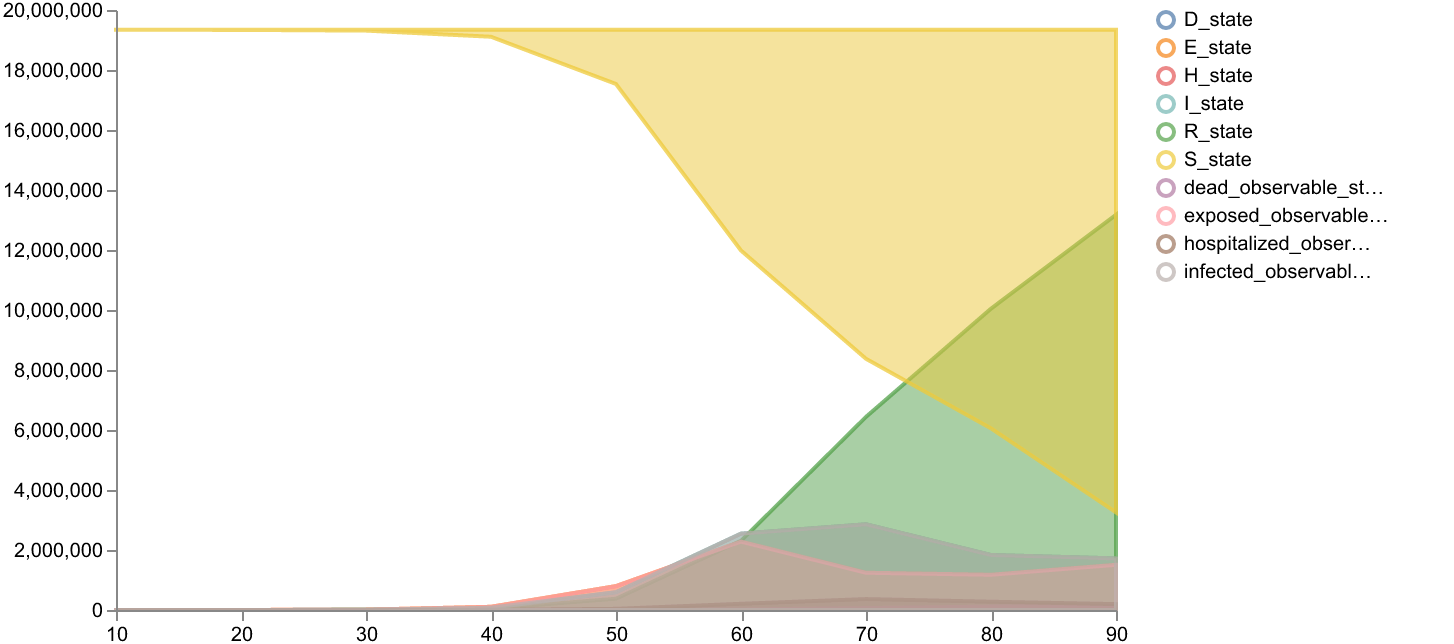

In [4]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Sample from model 2

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_beta_nc_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.524221,0.459527,0.205454,0.235196,0.067984,0.090239,14.974008,0.194733,22.429312,1.746075,25.282732,55.485363,19339936.0,25.282732,22.429312,1.746075,0.194733
1,1,0,20.0,0.524221,0.459527,0.205454,0.235196,0.067984,0.090239,14.974008,0.526808,19.035934,1.820207,21.692953,110.299667,19339860.0,21.692953,19.035934,1.820207,0.526808
2,2,0,30.0,0.524221,0.459527,0.205454,0.235196,0.067984,0.090239,14.974008,0.836248,16.245914,1.599038,18.515680,157.398010,19339866.0,18.515680,16.245914,1.599038,0.836248
3,3,0,40.0,0.524221,0.459527,0.205454,0.235196,0.067984,0.090239,14.974008,1.103904,13.865586,1.370922,15.802849,197.632080,19339814.0,15.802849,13.865586,1.370922,1.103904
4,4,0,50.0,0.524221,0.459527,0.205454,0.235196,0.067984,0.090239,14.974008,1.332824,11.833994,1.170893,13.487454,231.976288,19339780.0,13.487454,11.833994,1.170893,1.332824


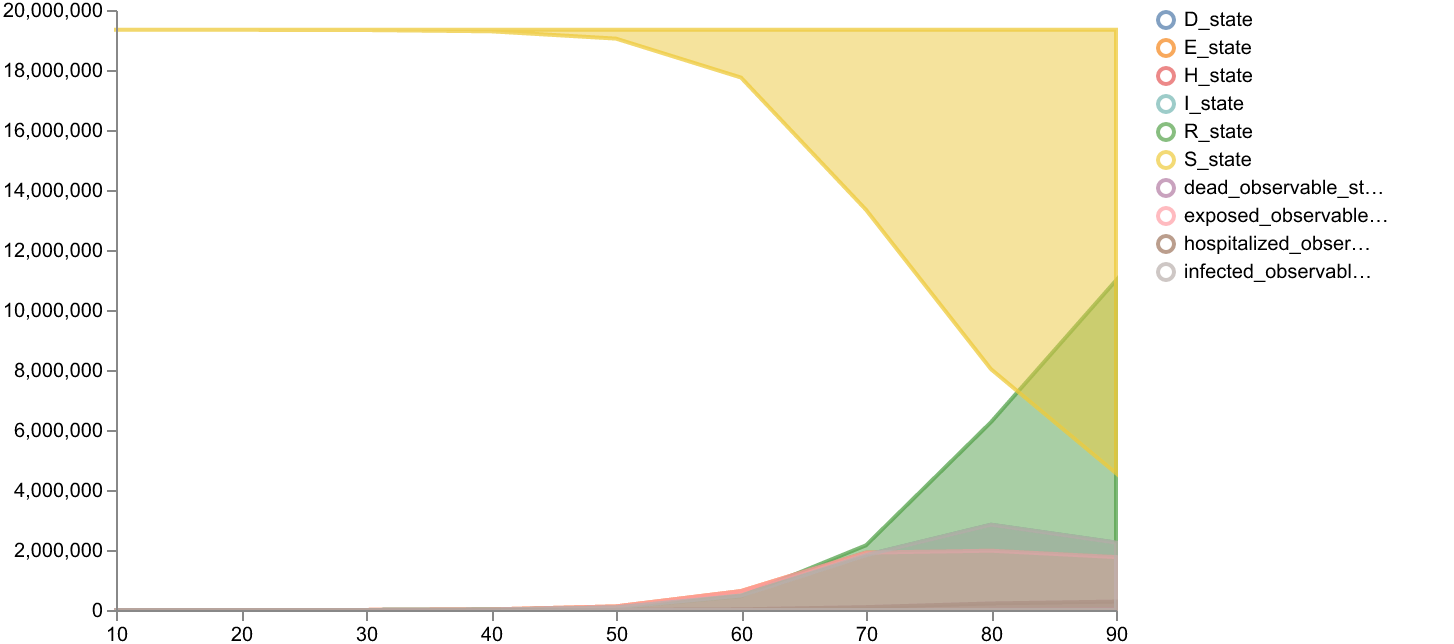

In [5]:
result2 = pyciemss.sample(model2, end_time, logging_step_size, num_samples, start_time=start_time)
display(result2['data'].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result2["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Ensemble Sample Interface
Sample from an ensemble of model 1 and model 2 

,timepoint_id,sample_id,timepoint_unknown,model_0/weight_param,model_1/weight_param,model_0/persistent_beta_c_param,model_0/persistent_kappa_param,model_0/persistent_gamma_param,model_0/persistent_hosp_param,model_0/persistent_death_hosp_param,...,D_state,E_state,H_state,I_state,R_state,S_state,infected_state,exposed_state,hospitalized_state,dead_state
0,0,0,10.0,0.005418,0.994582,0.680138,0.159649,0.27708,0.102003,0.094794,...,0.085306,2.802979e+02,1.445003,1.798671e+02,8.992397e+01,19339488.0,1.798671e+02,2.802979e+02,1.445003,0.085306
1,1,0,20.0,0.005418,0.994582,0.680138,0.159649,0.27708,0.102003,0.094794,...,1.251195,3.382547e+03,17.613712,2.170827e+03,1.195653e+03,19333272.0,2.170827e+03,3.382547e+03,17.613712,1.251195
2,2,0,30.0,0.005418,0.994582,0.680138,0.159649,0.27708,0.102003,0.094794,...,15.317924,4.066985e+04,212.284058,2.614526e+04,1.452782e+04,19258464.0,2.614526e+04,4.066985e+04,212.284058,15.317924
3,3,0,40.0,0.005418,0.994582,0.680138,0.159649,0.27708,0.102003,0.094794,...,183.299164,4.661987e+05,2511.487549,3.058451e+05,1.727827e+05,18392514.0,3.058451e+05,4.661987e+05,2511.487549,183.299164
4,4,0,50.0,0.005418,0.994582,0.680138,0.159649,0.27708,0.102003,0.094794,...,1980.182495,3.301438e+06,24397.673828,2.654366e+06,1.763890e+06,11593964.0,2.654366e+06,3.301438e+06,24397.673828,1980.182495


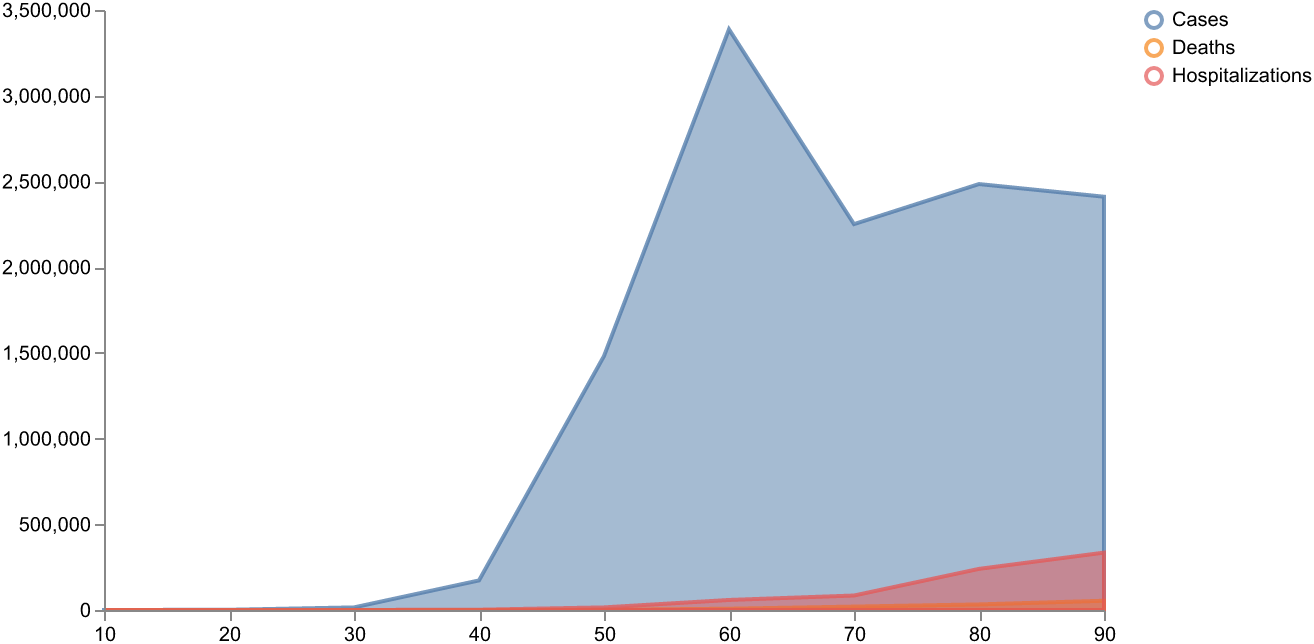

In [6]:
model_paths = [model1, model2]
solution_mappings = [lambda x : x, lambda x : x] # Conveniently, these two models operate on exactly the same state space, with the same names.

ensemble_result = pyciemss.ensemble_sample(model_paths, solution_mappings, end_time, logging_step_size, num_samples, start_time=start_time)
display(ensemble_result['data'].head())

# Plot the ensemble result for cases, hospitalizations, and deaths
nice_labels={"dead_state": "Deaths", 
                 "hospitalized_state": "Hospitalizations",
                 "infected_state": "Cases"
                }
schema = plots.trajectories(ensemble_result["data"], 
                           keep=["infected_state", "hospitalized_state", "dead_state"], 
                           relabel=nice_labels,
                          )
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Calibrate interface
Calibrate a model to a dataset by mapping model state varibales or observables to columns in the dataset. The `data_mapping` must be a dictionary where the keys are column names in the dataset, and the values are the state variables or observables they are mapped to (as in, `data_mapping = {"column_name": "observable/state_variable"}`).

In [7]:
data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10 if smoke_test else 1000
calibrated_results = pyciemss.calibrate(model1, dataset1, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_results["inferred_parameters"]
calibrated_results

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 3269.362817853689}

In [8]:
parameter_estimates()

{'persistent_beta_c': tensor(0.7217, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.4857, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.4816, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1128, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0708, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(14.9581, grad_fn=<ExpandBackward0>)}

### Use calibrated parameter estimates in `sample` to sample from the calibrated model (posterior distr.)

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,D_state,E_state,H_state,I_state,R_state,S_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,10.0,0.46188,0.158455,0.137875,0.099825,0.012753,4.590827,0.020995,19.004990,1.574449,30.401707,30.667612,19339960.0,30.401707,19.004990,1.574449,0.020995
1,1,0,20.0,0.46188,0.158455,0.137875,0.099825,0.012753,4.590827,0.070478,21.127264,2.205528,35.024830,75.177101,19339916.0,35.024830,21.127264,2.205528,0.070478
2,2,0,30.0,0.46188,0.158455,0.137875,0.099825,0.012753,4.590827,0.131471,24.012928,2.567582,39.831615,126.290031,19339858.0,39.831615,24.012928,2.567582,0.131471
3,3,0,40.0,0.46188,0.158455,0.137875,0.099825,0.012753,4.590827,0.201483,27.302422,2.927513,45.288605,184.459213,19339786.0,45.288605,27.302422,2.927513,0.201483
4,4,0,50.0,0.46188,0.158455,0.137875,0.099825,0.012753,4.590827,0.281176,31.042614,3.329677,51.492874,250.604401,19339708.0,51.492874,31.042614,3.329677,0.281176


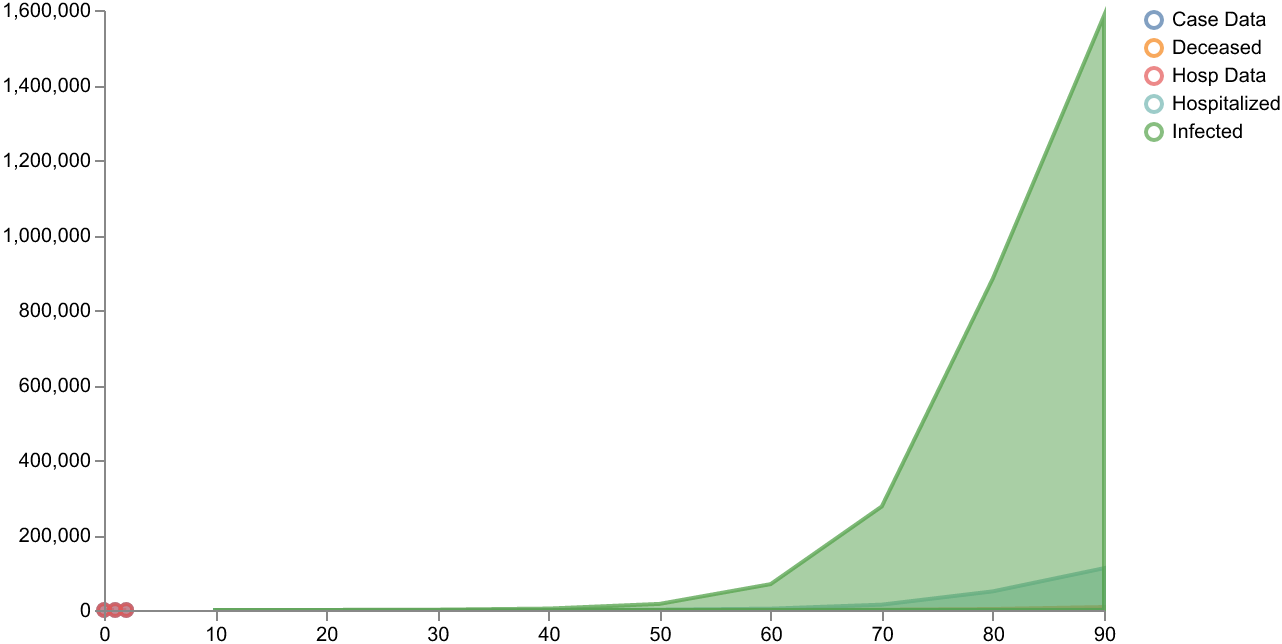

In [9]:
calibrated_sample_results = pyciemss.sample(model1, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "dead_observable_state": "Deceased", 
        "hospitalized_observable_state": "Hospitalized",
        "infected_observable_state": "Infected",
        }
nice_data_names = {
        "case": "Case Data",
        "hosp": "Hosp Data"
        }
data_df = pd.read_csv(dataset1)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(pd.DataFrame(calibrated_sample_results["data"]), 
                           keep=["infected_observable_state", "hospitalized_observable_state", "dead_observable_state"], 
                           relabel=nice_labels,
                           points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
                           )

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Sample interface with static parameter intervention
Change the value of the parameter `p_cbeta` to 0.5 on day 1

In [12]:
start_time = 0.0
end_time = 100.0
logging_step_size = 1.0
num_samples = 5 if smoke_test else 100

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(1.): {"p_cbeta": torch.tensor(0.5)}})
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

RuntimeError: The size of tensor a (300) must match the size of tensor b (3) at non-singleton dimension 0
                               Trace Shapes:      
                                Param Sites:      
numeric_deriv_func$$$_nodes.0._args.0._value      
numeric_deriv_func$$$_nodes.1._args.0._value      
                               Sample Sites:      
                     persistent_p_cbeta dist 100 |
                                       value 100 |
                        persistent_p_tr dist 100 |
                                       value 100 |

## Sample interface with static state intervention
Change the Infected state `I` to 20.0 on day 5

In [15]:
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_state_interventions={torch.tensor(5.): {"I": torch.tensor(20.0)}}, solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

ERROR:root:
                ###############################

                There was an exception in pyciemss

                Error occured in function: sample

                Function docs : 
    Load a model from a file, compile it into a probabilistic program, and sample from it.

    Args:
        model_path_or_json: Union[str, Dict]
            - A path to a AMR model file or JSON containing a model in AMR form.
        end_time: float
            - The end time of the sampled simulation.
        logging_step_size: float
            - The step size to use for logging the trajectory.
        num_samples: int
            - The number of samples to draw from the model.
        solver_method: str
            - The method to use for solving the ODE. See torchdiffeq's `odeint` method for more details.
            - If performance is incredibly slow, we suggest using `euler` to debug.
              If using `euler` results in faster simulation, the issue is likely that the model is s

RuntimeError: The size of tensor a (300) must match the size of tensor b (3) at non-singleton dimension 0
                               Trace Shapes:      
                                Param Sites:      
numeric_deriv_func$$$_nodes.0._args.0._value      
numeric_deriv_func$$$_nodes.1._args.0._value      
                               Sample Sites:      
                     persistent_p_cbeta dist 100 |
                                       value 100 |
                        persistent_p_tr dist 100 |
                                       value 100 |

## Sample interface with dynamic parameter interventions
Change the parameter `p_cbeta` from 0.35 to 0.3 when the infectious population `I` exceeds 400.

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    return lambda time, state: state[var] - threshold  
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_parameter_interventions1 = {infection_threshold: {"p_cbeta": torch.tensor(0.3)}}

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_parameter_interventions=dynamic_parameter_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [ ]:
# # NOTE: If you change the solver to "euler", you need to specify the step size in `solver_options` as below:
# # Specify solver options including the step_size
# solver_options = {"step_size": 1e-2}  # Example step size, adjust as needed
# result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
#                          dynamic_parameter_interventions=dynamic_parameter_interventions1, 
#                          solver_method="euler",
#                          solver_options=solver_options)

## Sample interface with dynamic state interventions
Reduce the susceptible population `S` to 200.0 when infections `I` exceed 400. 

In [ ]:
# Define the threshold for when the intervention should be applied
def make_var_threshold(var: str, threshold: torch.Tensor):
    return lambda time, state: state[var] - threshold  
    
infection_threshold = make_var_threshold("I", torch.tensor(400.0))
dynamic_state_interventions1 = {infection_threshold: {"S": torch.tensor(200.0)}} 

result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         dynamic_state_interventions=dynamic_state_interventions1, 
                         solver_method="dopri5")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Optimize interface
Get infections below 300 individuals at 100 days for SIR model with minimum change to current value for intervention parameter

In [ ]:
import numpy as np
from typing import Dict, List

def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()

    return np.mean(dataQoI[:, -ndays:], axis=1)

start_time = 0.0
end_time = 40.
logging_step_size = 1.0
observed_params = ["I_state"]
intervention_time = torch.tensor(1.)
intervened_params = "p_cbeta"
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]

risk_bound = 300.
qoi = lambda x: obs_nday_average_qoi(x, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current-x)
static_parameter_interventions = {intervention_time: intervened_params}

opt_result = pyciemss.optimize(model3, end_time, logging_step_size, qoi, risk_bound, static_parameter_interventions, objfun, 
                               initial_guess_interventions=initial_guess_interventions, bounds_interventions=bounds_interventions, 
                               start_time=0.0, n_samples_ouu=int(1e2), maxiter=1, maxfeval=20, solver_method="euler")
print(f'Optimal policy for intervening on {static_parameter_interventions[list(static_parameter_interventions.keys())[0]]} is ', opt_result["policy"])

#### Sample using optimal policy as intervention

In [ ]:
num_samples = 10 if smoke_test else 100
result = pyciemss.sample(model3, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={intervention_time: {intervened_params: opt_result["policy"]}}, 
                         solver_method="euler")
display(result["data"].head())

# Plot the result
schema = plots.trajectories(pd.DataFrame(result["data"]), keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)